### 衡量预测结果的 BDBR 性能 -> PSNR

需要对比的内容包括：
1. fast CAE -> proposed
2. original CAE
3. traditional fixed CRF

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 6)

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',  # 使用衬线字体
    'font.serif': ['Times New Roman'],  # 指定 Times New Roman 字体
    'font.size': 11,
    'text.usetex': False,
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.linewidth': 1,
    'axes.linewidth': 1
})
sns.set_style("whitegrid")
flierprops = dict(marker='o', markersize=2, linestyle='none')

table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
fig_dir   = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"

In [2]:
def rm_outliers(df, cols, threshold=1.5, lower_only=True):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        if lower_only:
            df = df[df[col] >= lower_bound]
        else:
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

#### 1. 预测的是 log2psnr

In [16]:
""" 把每个序列所有的 dataframe 叠在一起 """
import os
import re
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-log2psnr")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-log2psnr/{seq}")):
        if not re.search(r"(\d+P)", f):     # 只看一下 cross-preset 的结果
            convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-log2psnr/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/BDBR/convex_log2psnr.csv", index=False)

100%|██████████| 1026/1026 [00:01<00:00, 1023.52it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_log2psnr,log2psnr,psnr,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,pred_psnr,convex
0,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,1080P,22,5.612074,5.684724,51.436630,12.471467,12.639887,6382.4165,5679.181653,48.910557,pred
1,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,22,5.528016,5.577847,47.763832,9.673069,10.568373,1518.4389,816.364012,46.142240,pred
2,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,27,5.490352,5.476656,44.528451,9.036935,9.001844,512.6550,525.277025,44.953203,pred
3,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,32,5.445001,5.385978,41.815842,8.270977,7.294924,157.0330,308.895981,43.562092,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80526,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,1080P,27,5.527162,5.549708,46.841250,11.436992,11.465112,2827.1100,2772.538153,46.114944,fixed
80527,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,360P,27,5.352968,5.379552,41.630000,9.632173,9.615933,784.6650,793.547759,40.869934,fixed
80528,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,540P,27,5.424215,5.447910,43.650000,10.380215,10.374007,1327.0500,1332.772733,42.938950,fixed
80529,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,720P,27,5.468627,5.490891,44.970000,10.814260,10.824000,1812.7950,1800.597665,44.281344,fixed


In [17]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
from tqdm import tqdm
from fastCAE.metrics.bjontegaard import BD_PSNR, BD_RATE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

convex_df = pd.read_csv(f"{table_dir}/convex/convex_log2psnr.csv")
grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_rate_cae = BD_RATE(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    bd_psnr_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    
    bd_rate_fix = BD_RATE(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    bd_psnr_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate_cae, bd_psnr_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate_fix, bd_psnr_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_rate", "bd_psnr", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_psnr", "bd_rate"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_log2psnr.csv", index=False)

3564it [00:10, 326.43it/s]


,seqName,sceneId,regressor,func,input,preset,bd_rate,bd_psnr,anchor
0,Lecture-42c3,0,Adam,linear,faster,faster,4.461596,-0.336613,cae
1,Lecture-42c3,0,Adam,linear,faster,faster,-25.239822,1.569205,fixed
2,Lecture-42c3,0,Adam,linear,faster,medium,3.647282,-0.322759,cae
3,Lecture-42c3,0,Adam,linear,faster,medium,-29.679086,2.112849,fixed
...,...,...,...,...,...,...,...,...,...
7124,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,0.572146,-0.056046,cae
7125,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,-25.889169,1.177138,fixed
7126,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,0.000000,0.000000,cae
7127,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,-25.738131,1.163096,fixed


,sceneId,bd_rate,bd_psnr
count,6990.000000,6990.000000,6990.000000
mean,3.425465,-9.209083,0.426206
std,3.503298,15.006323,0.804347
min,0.000000,-42.104430,-1.119277
25%,1.000000,-22.016018,-0.241726
50%,2.000000,-6.886532,0.454098
75%,6.000000,4.381586,0.945452
max,11.000000,40.868419,5.464585


In [18]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_log2psnr.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_rate"].mean(), group["bd_psnr"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_rate", "bd_psnr", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_rate", "bd_psnr"], threshold=1.25).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_log2psnr.csv", index=False)

,regressor,func,input,bd_rate,bd_psnr,anchor
0,Adam,linear,faster,4.972928,-0.195282,cae
1,Adam,linear,medium,4.902965,-0.229965,cae
2,Adam,linear,slower,4.839322,-0.215671,cae
3,Adam,power,faster,6.261056,-0.376036,cae
...,...,...,...,...,...,...
104,SGDRegressor,power,slower,-23.495758,0.952262,fixed
105,SGDRegressor,quadratic2,faster,-23.125153,1.224723,fixed
106,SGDRegressor,quadratic2,medium,-22.723244,1.139448,fixed
107,SGDRegressor,quadratic2,slower,-23.011928,1.153027,fixed


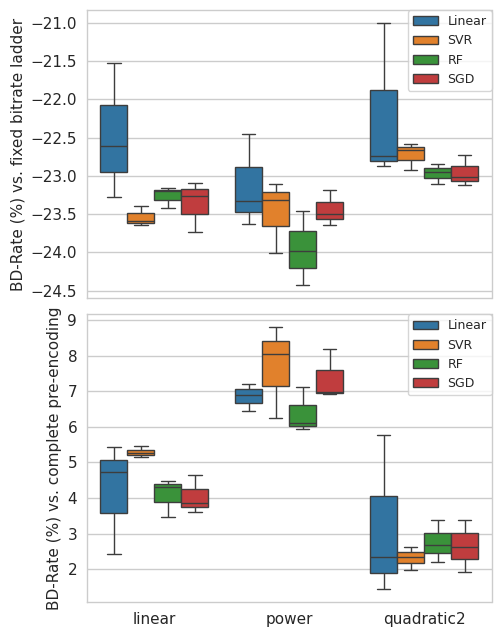

In [19]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 1. 先画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6.5), sharex=True)

sns.boxplot(ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_rate", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-Rate (%) vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="upper right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_rate", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-Rate (%) vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="upper right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bdrate_log2psnr.pdf", format="pdf")

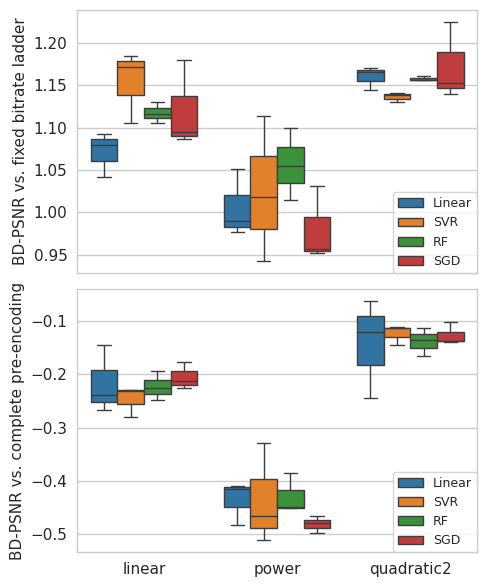

In [20]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)

# 2. 再画一下 BD-PSNR (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-PSNR vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-PSNR vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_log2psnr.pdf", format="pdf")

#### 2. 预测的是 psnr

In [21]:
""" 把每个序列所有的 dataframe 叠在一起 """
import os
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-psnr")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-psnr/{seq}")):
        if not re.search(r"(\d+P)", f):     # 只看一下 cross-preset 的结果
            convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-psnr/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/convex/convex_psnr.csv", index=False)

100%|██████████| 1022/1022 [00:00<00:00, 1142.15it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_psnr,log2psnr,psnr,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,convex
0,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,52,35.620311,5.199501,36.745625,3.908915,4.393753,21.0209,15.021062,pred
1,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,1080P,22,49.082082,5.684724,51.436630,12.471467,12.639887,6382.4165,5679.181653,pred
2,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,1080P,27,47.673450,5.606009,48.705380,11.697744,11.709526,3349.0265,3321.786631,pred
3,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,22,45.575342,5.577847,47.763832,9.673069,10.568373,1518.4389,816.364012,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79058,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,1080P,27,45.935300,5.549708,46.841250,11.436992,11.465112,2827.1100,2772.538153,fixed
79059,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,360P,27,40.960292,5.379552,41.630000,9.632173,9.615933,784.6650,793.547759,fixed
79060,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,540P,27,42.923398,5.447910,43.650000,10.380215,10.374007,1327.0500,1332.772733,fixed
79061,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,720P,27,44.205559,5.490891,44.970000,10.814260,10.824000,1812.7950,1800.597665,fixed


In [22]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
import sys
sys.path.append("../")

from metrics.bjontegaard import BD_PSNR, BD_RATE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_rate_cae = BD_RATE(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    bd_psnr_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    
    bd_rate_fix = BD_RATE(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    bd_psnr_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate_cae, bd_psnr_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate_fix, bd_psnr_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_rate", "bd_psnr", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_psnr", "bd_rate"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_psnr.csv", index=False)

3480it [00:09, 349.32it/s]


,seqName,sceneId,regressor,func,input,preset,bd_rate,bd_psnr,anchor
0,Lecture-42c3,0,Adam,linear,faster,faster,4.101703,-0.307013,cae
1,Lecture-42c3,0,Adam,linear,faster,faster,-25.057643,1.552586,fixed
2,Lecture-42c3,0,Adam,linear,faster,medium,-0.435014,0.046658,cae
3,Lecture-42c3,0,Adam,linear,faster,medium,-26.752264,1.819484,fixed
...,...,...,...,...,...,...,...,...,...
6956,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,0.572146,-0.056046,cae
6957,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,-25.889169,1.177138,fixed
6958,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,0.000000,0.000000,cae
6959,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,-25.738131,1.163096,fixed


,sceneId,bd_rate,bd_psnr
count,6745.000000,6745.000000,6745.000000
mean,3.424759,-9.284888,0.421835
std,3.504024,14.605390,0.774817
min,0.000000,-40.186930,-1.006206
25%,1.000000,-21.706650,-0.161691
50%,2.000000,-4.054247,0.143641
75%,6.000000,2.878401,0.925431
max,11.000000,45.788318,4.903406


In [23]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_psnr.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_rate"].mean(), group["bd_psnr"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_rate", "bd_psnr", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_rate", "bd_psnr"], threshold=1.25).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_psnr.csv", index=False)

,regressor,func,input,bd_rate,bd_psnr,anchor
0,Adam,linear,faster,3.772778,-0.135514,cae
1,Adam,linear,medium,2.458020,-0.085697,cae
2,Adam,linear,slower,2.174865,-0.091751,cae
3,Adam,power,faster,4.467159,-0.320569,cae
...,...,...,...,...,...,...
104,SGDRegressor,power,slower,-23.507415,0.943927,fixed
105,SGDRegressor,quadratic2,faster,-22.053749,1.118262,fixed
106,SGDRegressor,quadratic2,medium,-22.190055,1.096946,fixed
107,SGDRegressor,quadratic2,slower,-22.187363,1.100164,fixed


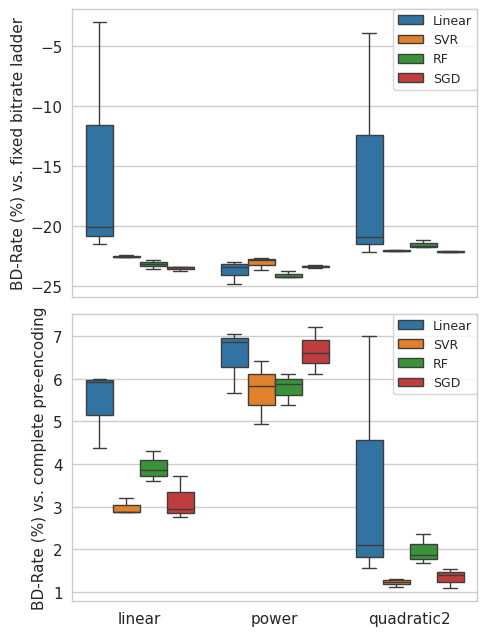

In [25]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 1. 先画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6.5), sharex=True)

sns.boxplot(ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_rate", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-Rate (%) vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="upper right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_rate", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-Rate (%) vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="upper right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bdrate_psnr.pdf", format="pdf")

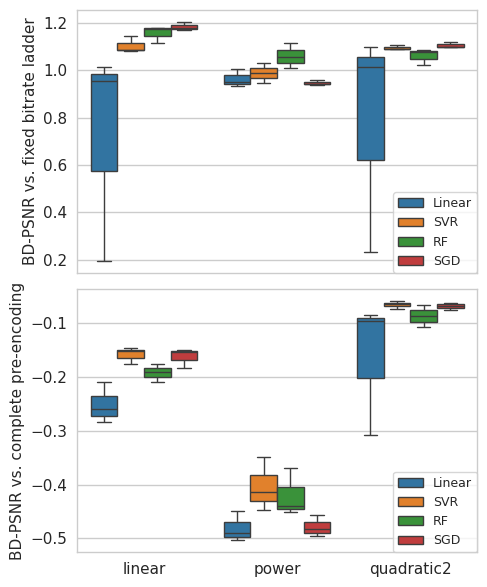

In [26]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)

# 2. 再画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-PSNR vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-PSNR vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_psnr.pdf", format="pdf")